<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/VAE_prob/Multivariate_Normal_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://python.quantecon.org/multivariate_normal.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import njit
import statsmodels.api as sm

$z \sim \mathcal{N}(\mu, \Sigma)$, $z \in \mathbb{R}^{N \times 1}$, which means:

\begin{equation}
    f(z; \mu, \Sigma) = (2\pi)^{-\frac{N}{2}} \det (\Sigma)^{-\frac{1}{2}} \exp(-.5 (z-\mu)' \Sigma^{-1} (z-\mu))
\end{equation}

$\mu = \mathbb{E}(z)$ is the mean of the random vector $z$, $\Sigma = \mathbb{E} (z-\mu)(z-\mu)'$ is the covariance matrix of $z$


the covariance matrix $\Sigma$ is symmetric and positive definite

In [9]:
@njit
def f(z, mu, cov):
    z = np.atleast_2d(z)
    mu = np.atleast_2d(mu)
    cov = np.atleast_2d(cov)
    N = z.size

    temp_1 = np.linalg.det(cov) ** (-1/2)  # det(Σ)−0.5
    temp_2 = np.exp(-.5 * (z - mu).T @ np.linalg.inv(cov) @ (z - mu)) # exp(−.5(𝑧−𝜇)′Σ−1(𝑧−𝜇))

    return (2 * np.pi) **(-N/2) * temp_1 * temp_2

for $k \in \{1, \dots, N-1\}$, partition z as
\begin{align}
z = \begin{bmatrix}
    z_1 \\
    z_2
\end{bmatrix}
\end{align}

$z_1 \in \mathbb{R}^{(N-k)\times 1}, z_2 \in \mathbb{R}^{(k)\times 1}$

Let
\begin{align}
\mu = \begin{bmatrix}
    \mu_1 \\
    \mu_2
\end{bmatrix},
\Sigma = \begin{bmatrix}
    \Sigma_{11}  \Sigma_{12} \\
    \Sigma_{21}  \Sigma_{22}
\end{bmatrix}
\end{align}

$z \sim \mathcal{N}(\mu, \Sigma)$, $z \in \mathbb{R}^{N \times 1}$

$z_1 \sim \mathcal{N}(\mu_1, \Sigma_{11})$,

$z_2 \sim \mathcal{N}(\mu_2, \Sigma_{22})$,


$z_1 | z_2 \sim \mathcal{N}(\hat{\mu_1}, \hat{\Sigma}_{11}) $, where
\begin{align}
    \hat{\mu_1} & = \mu_1 + \beta (z_2 - \mu_2)  \\
    \hat{\Sigma}_{11} & = \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21} = \Sigma_{11} - \beta \Sigma_{22} \beta' \\
    \beta & = \Sigma_{12} \Sigma_{22}^{-1}
\end{align}

  <!-- \begin{align}
    y &= \begin{bmatrix}
           x_{1} \\
           x_{2} \\
           \vdots \\
           x_{m}
         \end{bmatrix}
  \end{align} -->

In [10]:
class MultivariateNormal:
    def __init__(self, mu, cov):
        self.mu = np.array(mu)
        self.cov = np.atleast_2d(cov)
    def partition(self, k):
        mu = self.mu
        cov = self.cov

        self.mu_ = [mu[:k], mu[k:]]
        self.cov_ = [[cov[:k, :k], cov[:k, k:]],
                     [cov[k:, :k], cov[k:, k:]]]
        self.beta_ = [self.cov_[0][1] @ np.linalg.inv(self.cov_[1][1]), # Σ12Σ22^{-1}
                      self.cov_[1][0] @ np.linalg.inv(self.cov_[0][0])]

    def cond_dist(self, ind, z): # conditional distribution
    # ind = 0:  z1 | z2
    # ind = 1:  z2 | z1
        beta = self.beta_[ind] # beta also matrix
        mu_ = self.mu_
        cov_ = self.cov_

        mu_hat = mu_[ind] + beta @ (z - mu_[1-ind])
        cov_hat = cov_[ind][ind] - beta @ cov_[1-ind][1-ind] @ beta.T
        return mu_hat, cov_hat


In [11]:
μ = np.array([.5, 1.])
Σ = np.array([[1., .5], [.5 ,1.]])

# construction of the multivariate normal instance
multi_normal = MultivariateNormal(μ, Σ)

In [13]:
k = 1 # choose partition

# partition and compute regression coefficients
multi_normal.partition(k)
multi_normal.beta_[0],multi_normal.beta_[1]

(array([[0.5]]), array([[0.5]]))

$y_i = \theta + \sigma_y w_i, i = 1, \cdots, n$, $y_i$ is the test score of a person, and $\theta$ is the person's true IQ, but we do not know.

Assume $\theta = \mu_{\theta} + \sigma_{\theta} w_{n+1}$,

thus $y_i = \theta +\sigma_y w_i =  \mu_{\theta} + \sigma_{\theta} w_{n+1} +   \sigma_y w_i$

We assume $\{w_i\}_{i=1}^N$ in the test scores are IID and not correlated with IQ, we also assume:
\begin{align}
   w = \begin{bmatrix}
    w_1 \\
    w_2 \\
    \vdots \\
    w_n \\
    w_{n+1}
\end{bmatrix} \sim \mathcal{N} (0, I_{n+1})
\end{align}

\begin{align}
X & = \begin{bmatrix}
    y_1 \\
    y_2 \\
    \vdots \\
    y_n \\
    \theta
\end{bmatrix} = \begin{bmatrix}
\boldsymbol{y} \\
\theta \end{bmatrix} = \begin{bmatrix} \mu_{\theta} \\ \mu_{\theta} \\ \vdots \\ \mu_{\theta} \\ \mu_{\theta} \end{bmatrix} + \begin{bmatrix}
 \sigma_y & 0 & \dots & 0 & \sigma_{\theta} \\
 0 & \sigma_y & \dots & 0 & \sigma_{\theta} \\
 \vdots & \vdots & \ddots & \vdots & \vdots \\
 0 & 0 & \dots & \sigma_y & \sigma_{\theta} \\
0 & 0 & \dots & 0& \sigma_{\theta} \\
\end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_n \\ w_{n+1}\end{bmatrix}
 & = \mu_{\theta} \boldsymbol{1}_{n+1} + D\boldsymbol{w}
\end{align}

In [17]:
def construct_moments_IQ(n, mu_theta, sigma_theta, sigma_y):
    mu_IQ = np.full(n+1, mu_theta)  # array (n+1, )
    D_IQ = np.zeros((n+1, n+1))
    D_IQ[range(n), range(n)] = sigma_y
    D_IQ[:,n] = sigma_theta
    cov_IQ = D_IQ @ D_IQ.T
    return mu_IQ, cov_IQ, D_IQ

In [28]:
n = 50
μθ, σθ, σy = 100., 10., 10.
μ_IQ, Σ_IQ, D_IQ = construct_moments_IQ(n, μθ, σθ, σy)

In [29]:
multi_normal_IQ = MultivariateNormal(μ_IQ, Σ_IQ)
k = n
multi_normal_IQ.partition(k)

In [30]:
x = np.random.multivariate_normal(μ_IQ, Σ_IQ)
y = x[:-1] # test scores
θ = x[-1]  # IQ

In [31]:
θ

98.01764657770761

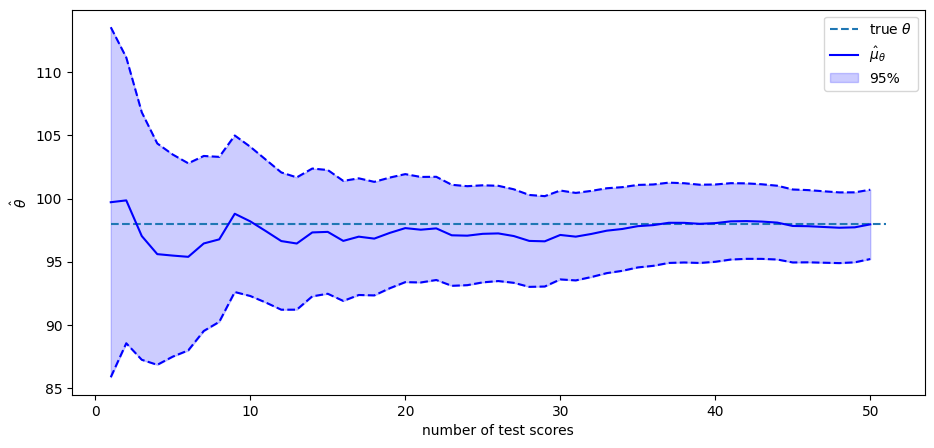

In [32]:
# array for containing moments
μθ_hat_arr = np.empty(n)
Σθ_hat_arr = np.empty(n)

# loop over number of test scores
for i in range(1, n+1):
    # construction of multivariate normal distribution instance
    μ_IQ_i, Σ_IQ_i, D_IQ_i = construct_moments_IQ(i, μθ, σθ, σy)
    multi_normal_IQ_i = MultivariateNormal(μ_IQ_i, Σ_IQ_i)

    # partition and compute conditional distribution
    multi_normal_IQ_i.partition(i)
    scores_i = y[:i]
    μθ_hat_i, Σθ_hat_i = multi_normal_IQ_i.cond_dist(1, scores_i)

    # store the results
    μθ_hat_arr[i-1] = μθ_hat_i[0]
    Σθ_hat_arr[i-1] = Σθ_hat_i[0, 0]

# transform variance to standard deviation
σθ_hat_arr = np.sqrt(Σθ_hat_arr)
μθ_hat_lower = μθ_hat_arr - 1.96 * σθ_hat_arr
μθ_hat_higher = μθ_hat_arr + 1.96 * σθ_hat_arr

plt.hlines(θ, 1, n+1, ls='--', label='true $θ$')
plt.plot(range(1, n+1), μθ_hat_arr, color='b', label='$\hat{μ}_{θ}$')
plt.plot(range(1, n+1), μθ_hat_lower, color='b', ls='--')
plt.plot(range(1, n+1), μθ_hat_higher, color='b', ls='--')
plt.fill_between(range(1, n+1), μθ_hat_lower, μθ_hat_higher,
                 color='b', alpha=0.2, label='95%')

plt.xlabel('number of test scores')
plt.ylabel('$\hat{θ}$')
plt.legend()

plt.show()

In [35]:
Σθ_hat_arr.shape

(50,)